In [1]:
import h5py
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# path_phot = '/scratch/05328/tg846280/GAIADR3_data/temp_gaia_edr3_data/all_w_rv_phot.h5'
path_spec = '/scratch/05328/tg846280/GAIADR3_data/temp_gaia_edr3_data/all_w_rv_spec.h5'
# df_phot = pd.read_hdf(path_phot)
df_spec = pd.read_hdf(path_spec)
# path_out = '/work2/08949/tg882489/stampede2/data/Ananke/GaiaDR3_data_reduced.hdf5'

FileNotFoundError: File /scratch/05328/tg846280/GAIADR3_data/temp_gaia_edr3_data/all_w_rv_spec.h5 does not exist

In [56]:
# df = pd.merge(df_phot, df_spec, on="source_id", how="inner")

In [57]:
fem = df_spec.fem_gspspec
mh = df_spec.mh_gspspec
source_id = df_spec.source_id

In [58]:
len(df_spec.fem_gspspec), len(df_spec.mh_gspspec), len(fem)

(33758668, 33758668, 33758668)

In [59]:
mask1 = (~np.isnan(mh))

In [60]:
fem = fem[mask1]
mh = mh[mask1]
source_id = source_id[mask1]

In [61]:
len(fem)

5510896

In [62]:
mask2 = (~np.isnan(fem))

In [63]:
fem = fem[mask2]
mh = mh[mask2]
source_id = source_id[mask2]

In [64]:
np.sum(np.isnan(fem)), np.sum(np.isnan(mh)), np.sum(np.isnan(source_id))

(0, 0, 0)

In [65]:
len(fem), len(mh), len(source_id)

(1760727, 1760727, 1760727)

In [66]:
feh = fem + mh

In [67]:
path = '/scratch/05328/tg846280/GAIADR3_data/temp_gaia_edr3_data/all_w_rv_kin.h5'
path_out = '/work2/08949/tg882489/stampede2/data/Ananke/GaiaDR3_data_reduced.hdf5'
df = pd.read_hdf(path)

In [68]:
main_source_id = df.source_id
parallax = df.parallax
parallax_error = df.parallax_error
poe = parallax/parallax_error
ra = df.ra
dec = df.dec
pmra = df.pmra
pmdec = df.pmdec
rv = df.radial_velocity

In [69]:
len(main_source_id), len(source_id)

(33812183, 1760727)

In [70]:
empt = np.zeros(len(main_source_id))/0

/tmp/ipykernel_208983/2133620579.py:1: RuntimeWarning: invalid value encountered in divide
  empt = np.zeros(len(main_source_id))/0


In [71]:
len(empt), len(feh), np.sum(mask_id)

(33812183, 1760727, 1712470)

In [72]:
mask_id = (np.isin(main_source_id, source_id))
empt[mask_id] = feh

In [75]:
feh = empt

In [76]:
np.sum(np.isnan(rv)), np.sum(np.isnan(feh)), len(rv), len(feh)

(0, 32051456, 33812183, 33812183)

In [77]:
non_null_mask = (~np.isnan(feh))
rv = rv[non_null_mask]
ra = ra[non_null_mask]
dec = dec[non_null_mask]
parallax = parallax[non_null_mask]
pmra = pmra[non_null_mask]
pmdec = pmdec[non_null_mask]
feh = feh[non_null_mask]
poe = poe[non_null_mask]

In [78]:
len(rv), len(df.source_id), len(ra)

(1760727, 33812183, 1760727)

In [80]:
mask_poe = (poe>10)
parallax = parallax[mask_poe]
ra = ra[mask_poe]
dec = dec[mask_poe]
pmra = pmra[mask_poe]
pmdec = pmdec[mask_poe]
rv = rv[mask_poe]
feh = feh[mask_poe]

In [81]:
rv = np.array(rv)
ra = np.array(ra)
dec = np.array(dec)
parallax = np.array(parallax)
pmra = np.array(pmra)
pmdec = np.array(pmdec)
feh = np.array(feh)


In [82]:
ra = ra * u.deg
dec = dec * u.deg
parallax = parallax * u.mas
rv = rv * u.km / u.s
pmra = pmra * u.mas / u.yr
pmdec = pmdec * u.mas / u.yr

dist = coord.Distance(parallax=parallax, allow_negative=True)

# Coord transformation
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
gal = icrs.transform_to(coord.Galactocentric())

In [83]:
z = gal.z.to_value(u.kpc)
vx = gal.v_x.to_value(u.km/u.s)
vy = gal.v_y.to_value(u.km/u.s)
vz = gal.v_z.to_value(u.km/u.s)  

In [84]:
len(z), z, len(feh)

(1712470,
 array([ 0.0375008 ,  0.02127315,  0.01086536, ...,  1.45078643,
         0.22712866, -2.79484051]),
 1712470)

In [85]:
mask_z = (np.absolute(z)>1.5)

In [86]:
z = z[mask_z]
vx = vx[mask_z]
vy = vy[mask_z]
vz = vz[mask_z]
feh = feh[mask_z]

In [87]:
len(z), np.sum(feh>=-1.5)

(25125, 24816)

In [88]:
mask_feh = (feh<-1.5)
z = z[mask_feh]
vx = vx[mask_feh]
vy = vy[mask_feh]
vz = vz[mask_feh]
feh = feh[mask_feh]

In [92]:
len(feh)/len(ra), len(z)

(0.00018044111721665198, 309)

In [90]:
vr = np.sqrt(vx**2+vz**2)

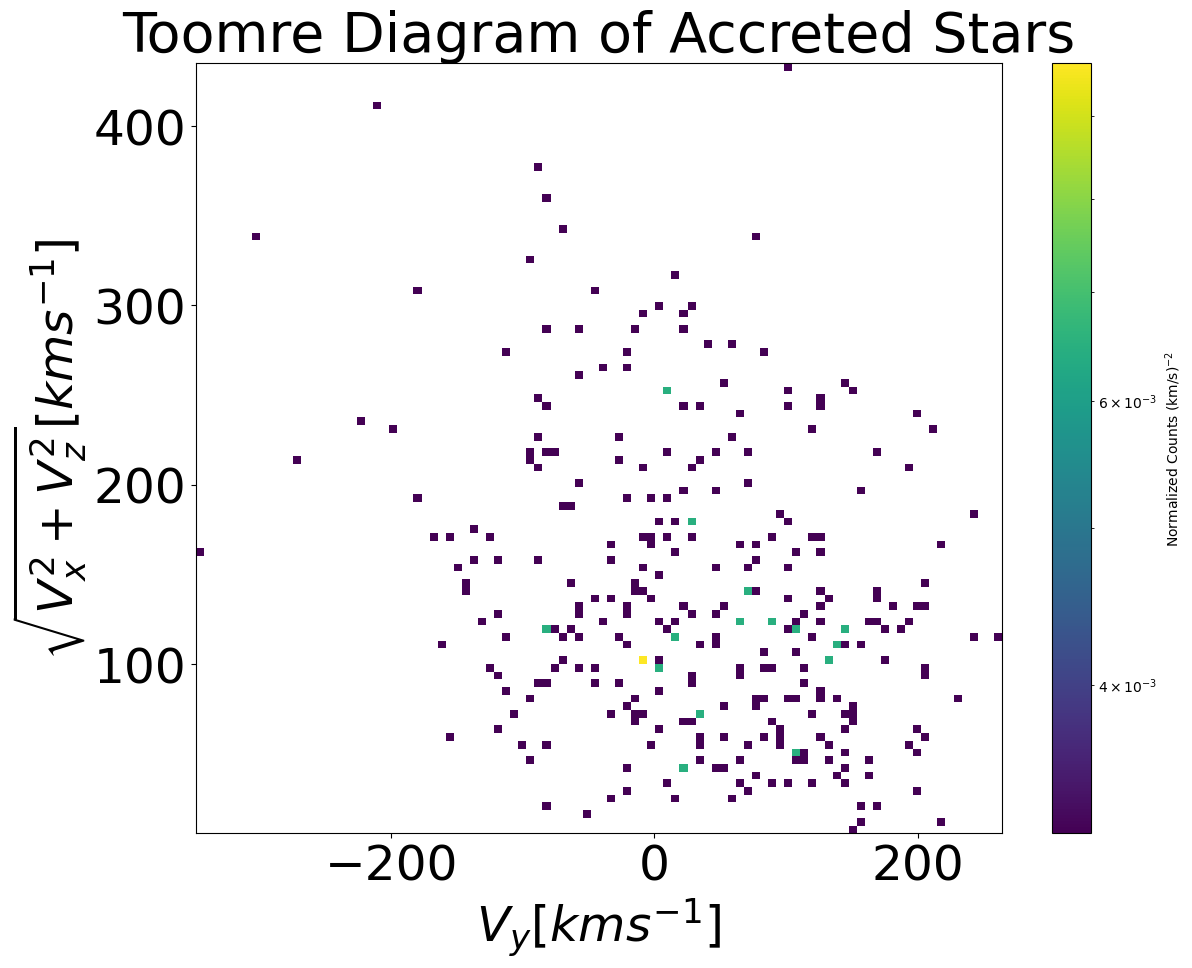

In [91]:
fig, ax = plt.subplots(1, figsize=(13, 10))

h = ax.hist2d(vy, vr, bins=100, weights=np.repeat(1/len(vx), len(vx)), norm=mpl.colors.LogNorm())
ax.set_xlabel(r'$V_y [km s^{-1}]$', fontsize=35)
ax.set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=35)
ax.set_title('Toomre Diagram of Accreted Stars', fontsize=40)
cb = fig.colorbar(h[3], ax=ax, label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=35)
ax.tick_params(axis='both', labelsize=35)